## Private Adoption

In [ ]:
# Imports and setup
from pathlib import Path
from copy import deepcopy
import numpy as np
import pandas as pd

# Input / Output
INPUT_CSV = "PrivateADOPTION2024-25.csv"
OUTDIR = Path("outputs_private")
OUTDIR.mkdir(parents=True, exist_ok=True)

# Time settings
START_YEAR = 2025
HORIZON_YEARS = 8  # 2025..2032


In [ ]:
# Scenario definitions for private hospitals
# Each scenario controls how fast adoption grows (r = speed, t0 = midpoint, K = cap).
SCENARIOS = {
    "Pessimistic": {"K": None, "r": 0.7, "t0": 4.0},   # 30% adoption
    "Moderate":    {"K": None, "r": 1.0, "t0": 3.0},   # 55% adoption
    "Optimistic":  {"K": None, "r": 1.3, "t0": 2.5},   # 80% adoption
}


### ARI weights

In [ ]:
# ARI weight sets
# These define how much weight is given to different adoption drivers.
WEIGHT_SETS = {
    "baseline": {
        "scans":           0.45,  # proxy for demand
        "past_ai":         0.20,  # readiness
        "req_to_test_inv": 0.20,  # friction (inverted)
        "ttr_inv":         0.15,  # friction (inverted)
    },
    "demand_tilt": {
        "scans":           0.40,
        "past_ai":         0.15,
        "req_to_test_inv": 0.25,
        "ttr_inv":         0.20,
    },
    "readiness_tilt": {
        "scans":           0.50,
        "past_ai":         0.25,
        "req_to_test_inv": 0.15,
        "ttr_inv":         0.10,
    },
    "balanced": {
        "scans":           0.35,
        "past_ai":         0.25,
        "req_to_test_inv": 0.20,
        "ttr_inv":         0.20,
    },
}

# Safety check: all weights must sum to 1
for name, w in WEIGHT_SETS.items():
    if not np.isclose(sum(w.values()), 1.0):
        raise ValueError(f"Weight set '{name}' must sum to 1.0 (got {sum(w.values()):.4f})")


In [ ]:
# Helper functions
def robust_scale(series: pd.Series) -> pd.Series:
    """Scale values around median using IQR (robust against outliers)."""
    s = pd.to_numeric(series, errors="coerce")
    med = s.median()
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    if pd.notna(iqr) and iqr != 0:
        out = (s - med) / iqr
    else:
        std = s.std(ddof=0)
        out = (s - med) / std if (pd.notna(std) and std != 0) else pd.Series(0.0, index=s.index)
    return out.fillna(0.0)

def minmax_0_100(series: pd.Series) -> pd.Series:
    """Normalize a numeric series to range [0,100]."""
    s = pd.to_numeric(series, errors="coerce").astype(float)
    lo, hi = s.min(), s.max()
    if not np.isfinite(lo) or not np.isfinite(hi) or hi == lo:
        return pd.Series(50.0, index=s.index)  # fallback if constant/invalid
    return 100.0 * (s - lo) / (hi - lo)

def logistic_cumulative_array(T: int, K: int, r: float, t0: float) -> np.ndarray:
    """Logistic growth curve: cumulative adopters over time."""
    t = np.arange(T, dtype=float)
    return K / (1.0 + np.exp(-r * (t - t0)))


In [ ]:
# Load and clean private adoption data
df = pd.read_csv(INPUT_CSV)

COL_PROVIDER = "Provider name"
COL_SCANS    = "No of Prostate Scans(5% of total)"
COL_TTR      = "Median Days Test to Report"
COL_REQ2TEST = "Median Days Request to test"
COL_PAST_AI  = "Past AI adoption"

# Convert to numeric and fill missing with medians
for c in [COL_SCANS, COL_TTR, COL_REQ2TEST]:
    df[c] = pd.to_numeric(df[c], errors="coerce")
    med = df[c].median()
    df[c] = df[c].fillna(med if pd.notna(med) else 0)

# Convert "Past AI adoption" column into binary flag
df["Past_AI_Flag"] = (
    df[COL_PAST_AI].astype(str).str.strip().str.lower()
      .map({"yes": 1, "no": 0})
      .fillna(0).astype(int)
)


In [ ]:
# Feature engineering for ARI
# Build standardised inputs for ARI (Adoption Readiness Index).
scaled = pd.DataFrame(index=df.index)
scaled["scans_z"]        = robust_scale(df[COL_SCANS])          # demand (+)
scaled["past_ai_bin"]    = df["Past_AI_Flag"].astype(float)     # readiness (+)
scaled["req_to_test_inv"] = -robust_scale(df[COL_REQ2TEST])     # friction (-)
scaled["ttr_inv"]         = -robust_scale(df[COL_TTR])          # friction (-)

def compute_private_ari(weights: dict) -> pd.Series:
    """Compute weighted ARI score given a weight set."""
    return (
        weights["scans"]           * scaled["scans_z"] +
        weights["past_ai"]         * scaled["past_ai_bin"] +
        weights["req_to_test_inv"] * scaled["req_to_test_inv"] +
        weights["ttr_inv"]         * scaled["ttr_inv"]
    )


### ARI

In [ ]:
# Baseline ARI ranking
# Rank private providers by readiness to adopt AI.
ari_raw_baseline = compute_private_ari(WEIGHT_SETS["baseline"])
ari_score = minmax_0_100(ari_raw_baseline)

ranked = (
    pd.DataFrame({
        "Provider": df[COL_PROVIDER],
        "ARI_Raw": ari_raw_baseline.round(6),
        "ARI_Score": ari_score.round(2),
        "Prostate_Scans": df[COL_SCANS],
        "PastAIAdoption": df["Past_AI_Flag"],
        "MedianDays_Request_to_Test": df[COL_REQ2TEST],
        "MedianDays_Test_to_Report": df[COL_TTR],
    })
    .sort_values(["ARI_Score", "ARI_Raw"], ascending=False)
    .reset_index(drop=True)
)
ranked.insert(0, "Rank", np.arange(1, len(ranked) + 1))

ranked_path = OUTDIR / "private_ari_scores_ranked.csv"
ranked.to_csv(ranked_path, index=False)
print("Saved ranked ARI ->", ranked_path.resolve())


Saved ranked ARI -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs_private\private_ari_scores_ranked.csv


In [ ]:
# Diffusion scenarios
# Build logistic adoption scenarios with different caps/speeds.
total_priv = len(ranked)
SCENARIOS_CAL = {
    "Pessimistic": {"K": int(round(0.30 * total_priv)), "r": 0.7, "t0": 4.0},
    "Moderate":    {"K": int(round(0.55 * total_priv)), "r": 1.0, "t0": 3.0},
    "Optimistic":  {"K": int(round(0.80 * total_priv)), "r": 1.3, "t0": 2.5},
}

def scenario_curve(years, K, r, t0, cap):
    """Compute cumulative and new adopters per year under logistic growth."""
    T = len(years)
    K_eff = min(int(K), int(cap))
    cum = logistic_cumulative_array(T, K_eff, r, t0)
    cum = np.clip(np.round(cum).astype(int), 0, cap)
    cum = np.maximum.accumulate(cum)
    cum[-1] = min(cum[-1], cap)
    new = np.diff(np.insert(cum, 0, 0))
    return cum, new


In [ ]:
# Functions for ARI and simulations
def compute_ari_for_weights(weights: dict) -> pd.Series:
    """Compute ARI for a given weight set (alternative mixes)."""
    return (
        weights["scans"]           * scaled["scans_z"] +
        weights["past_ai"]         * scaled["past_ai_bin"] +
        weights["req_to_test_inv"] * scaled["req_to_test_inv"] +
        weights["ttr_inv"]         * scaled["ttr_inv"]
    )

def rank_for_weightset(weights_name: str, weights: dict) -> pd.DataFrame:
    """Rank providers by ARI under a specific weight set."""
    raw = compute_ari_for_weights(weights)
    score = minmax_0_100(raw)
    out = (
        pd.DataFrame({
            "Provider": df[COL_PROVIDER],
            "ARI_Raw": raw.round(6),
            "ARI_Score": score.round(2),
        })
        .sort_values(["ARI_Score", "ARI_Raw"], ascending=False)
        .reset_index(drop=True)
    )
    out.insert(0, "Rank", np.arange(1, len(out) + 1))
    out["Weights_Set"] = weights_name
    return out

def simulate_from_ranked(ranked_df: pd.DataFrame, scenarios_dict: dict, variant_name: str):
    """Simulate adoption schedules + assignments given ranked providers and scenario variant."""
    years = list(range(START_YEAR, START_YEAR + HORIZON_YEARS))
    cap = len(ranked_df)
    schedules, assignments = [], []

    for scen_name, p in scenarios_dict.items():
        cum, new = scenario_curve(years, p["K"], p["r"], p["t0"], cap)
        df_sched = pd.DataFrame({"Year": years, "New_Adopters": new, "Cumulative_Adopters": cum})
        df_sched["Scenario"] = scen_name
        df_sched["Scenario_Variant"] = variant_name
        schedules.append(df_sched)

        rows, cursor = [], 0
        for y, n in zip(years, new):
            if n <= 0: continue
            end = min(cursor + int(n), cap)
            if end > cursor:
                batch = ranked_df.loc[cursor:end-1, ["Provider","ARI_Score","ARI_Raw"]].copy()
                batch["AdoptionYear"] = y
                batch["Scenario"] = scen_name
                batch["Scenario_Variant"] = variant_name
                rows.append(batch)
            cursor = end
            if cursor >= cap: break
        assignments.append(pd.concat(rows, ignore_index=True) if rows else
                           pd.DataFrame(columns=["Provider","ARI_Score","ARI_Raw","AdoptionYear","Scenario","Scenario_Variant"]))

    return pd.concat(schedules, ignore_index=True), pd.concat(assignments, ignore_index=True)


In [ ]:
#  Run sensitivity grid
all_rankings, all_schedules, all_assignments = [], [], []
for wname, w in WEIGHT_SETS.items():
    ranked_ws = rank_for_weightset(wname, w)
    all_rankings.append(ranked_ws)
    for variant, scen in SCENARIOS_VARIANTS.items():
        sched, assign = simulate_from_ranked(ranked_ws, scen, variant)
        sched["Weights_Set"] = wname
        assign["Weights_Set"] = wname
        all_schedules.append(sched)
        all_assignments.append(assign)

rankings_all   = pd.concat(all_rankings, ignore_index=True)
schedules_all  = pd.concat(all_schedules, ignore_index=True)
assignments_all= pd.concat(all_assignments, ignore_index=True)

rankings_all.to_csv(OUTDIR / "private_ari_sensitivity_rankings.csv", index=False)
schedules_all.to_csv(OUTDIR / "private_ari_sensitivity_schedules.csv", index=False)
assignments_all.to_csv(OUTDIR / "private_ari_sensitivity_assignments.csv", index=False)


In [ ]:
#  Milestone summary
milestones = [START_YEAR + 1, START_YEAR + 3, START_YEAR + HORIZON_YEARS - 1]
rows = []
for (wset, svar, scen), grp in schedules_all.groupby(["Weights_Set","Scenario_Variant","Scenario"]):
    r = {"Weights_Set": wset, "Scenario_Variant": svar, "Scenario": scen}
    for m in milestones:
        r[f"Adopters_by_{m}"] = int(grp.loc[grp["Year"] <= m, "Cumulative_Adopters"].max())
    r["Adopters_by_end"] = int(grp["Cumulative_Adopters"].max())
    rows.append(r)

summary_df = pd.DataFrame(rows).sort_values(["Scenario_Variant","Scenario","Weights_Set"]).reset_index(drop=True)
summary_df.to_csv(OUTDIR / "private_ari_sensitivity_summary.csv", index=False)

print("Saved:")
print(" - Rankings   ->", (OUTDIR / "private_ari_sensitivity_rankings.csv").resolve())
print(" - Schedules  ->", (OUTDIR / "private_ari_sensitivity_schedules.csv").resolve())
print(" - Assignments->", (OUTDIR / "private_ari_sensitivity_assignments.csv").resolve())
print(" - Summary    ->", (OUTDIR / "private_ari_sensitivity_summary.csv").resolve())


Saved:
 - Rankings   -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs_private\private_ari_sensitivity_rankings.csv
 - Schedules  -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs_private\private_ari_sensitivity_schedules.csv
 - Assignments-> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs_private\private_ari_sensitivity_assignments.csv
 - Summary    -> C:\Users\PAVILION\OneDrive - Queen Mary, University of London\Quibim\FINAL_CODES\ADOPTION\outputs_private\private_ari_sensitivity_summary.csv


### Adoption Plots

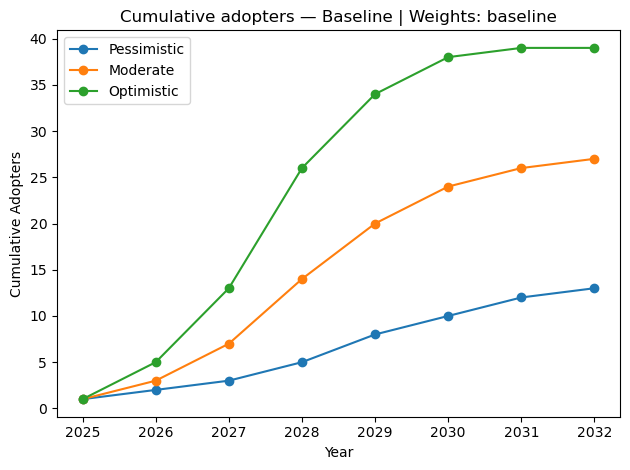

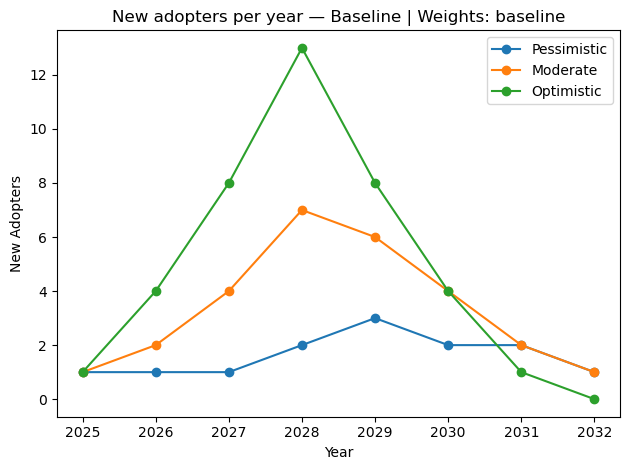

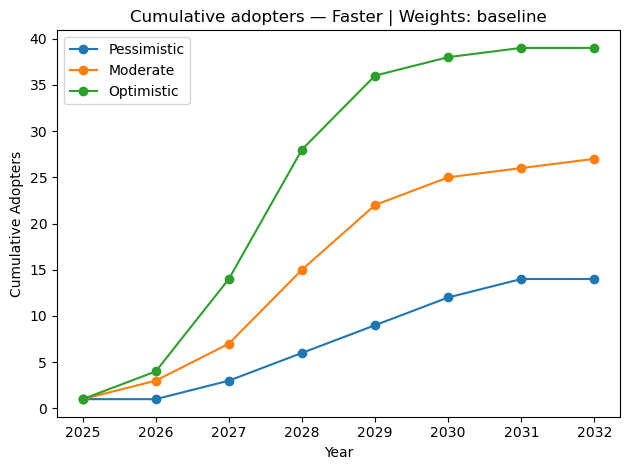

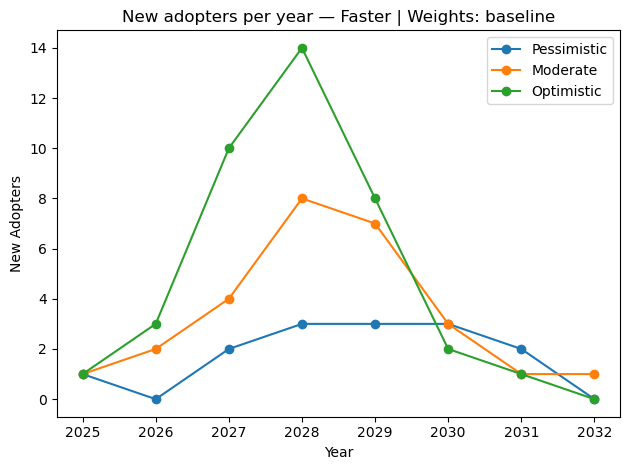

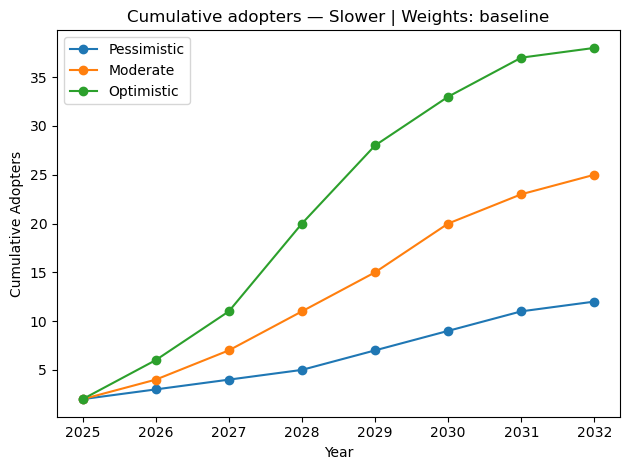

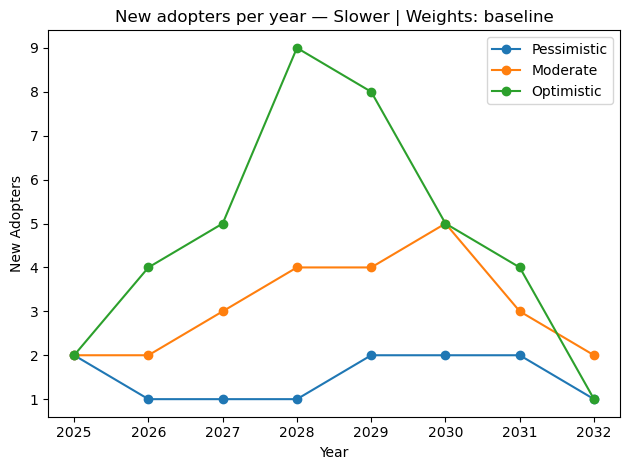

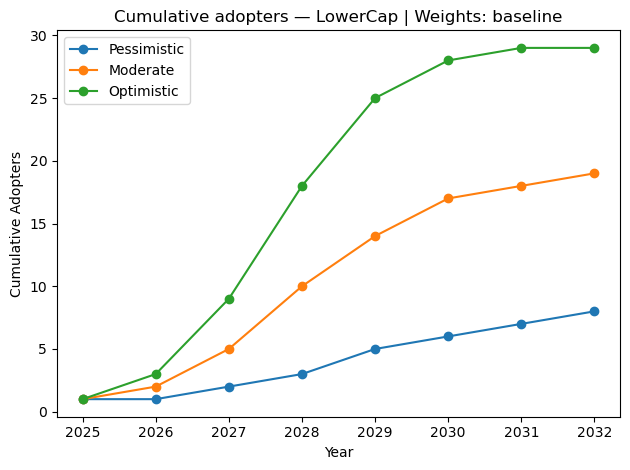

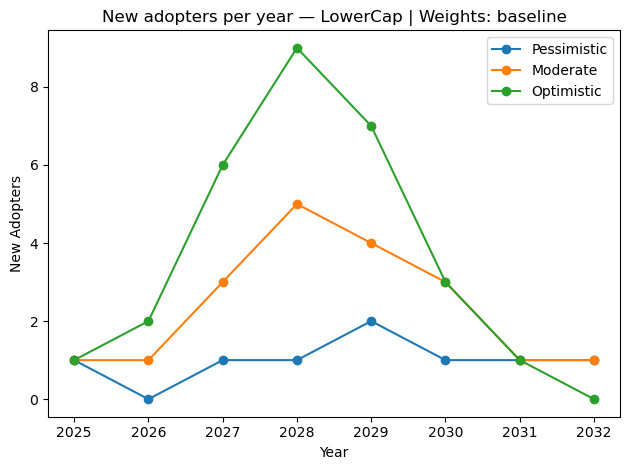

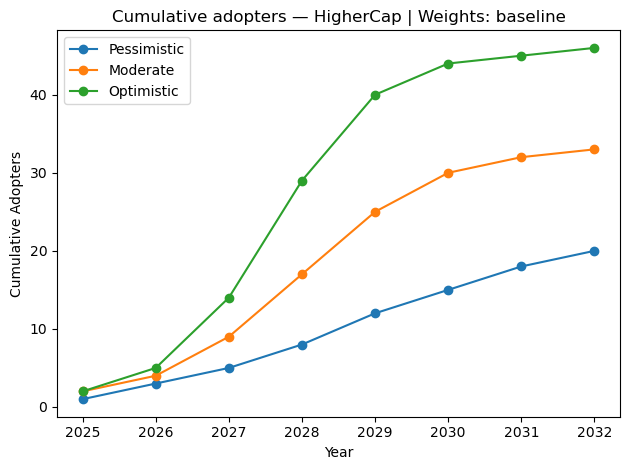

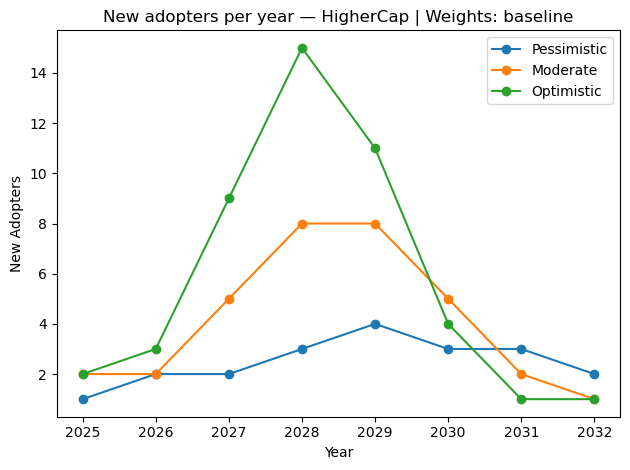

In [ ]:
# Plots for baseline weights
import matplotlib.pyplot as plt

def plot_for_weightset(weight_set_name="baseline"):
    ws_ranked = rankings_all[rankings_all["Weights_Set"] == weight_set_name].copy()
    for variant in schedules_all["Scenario_Variant"].unique():
        dfv = schedules_all[(schedules_all["Weights_Set"] == weight_set_name) &
                            (schedules_all["Scenario_Variant"] == variant)]
        years = sorted(dfv["Year"].unique())

        plt.figure()
        for scen in ["Pessimistic","Moderate","Optimistic"]:
            s = dfv[dfv["Scenario"] == scen].sort_values("Year")
            plt.plot(s["Year"], s["Cumulative_Adopters"], marker="o", label=scen)
        plt.title(f"Cumulative adopters — {variant} | Weights: {weight_set_name}")
        plt.xlabel("Year"); plt.ylabel("Cumulative Adopters"); plt.legend(); plt.tight_layout(); plt.show()

        plt.figure()
        for scen in ["Pessimistic","Moderate","Optimistic"]:
            s = dfv[dfv["Scenario"] == scen].sort_values("Year")
            plt.plot(s["Year"], s["New_Adopters"], marker="o", label=scen)
        plt.title(f"New adopters per year — {variant} | Weights: {weight_set_name}")
        plt.xlabel("Year"); plt.ylabel("New Adopters"); plt.legend(); plt.tight_layout(); plt.show()

plot_for_weightset("baseline")
